In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Batting", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Batting", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Batting", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Cut', 'Drive', 'Leg Shot', 'PullShot', 'Scoop', 'Straight', 'Sweep']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 5814
Total validation images: 1494
Total test images: 1863
Total images in dataset: 9171


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 5168
Validation images (excluding 'random_occlusion'): 1328
Test images (excluding 'random_occlusion'): 1656
Total images (excluding 'random_occlusion'): 8152


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution'}
Validation folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution'}
Test folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Batting", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Batting", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Batting", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Cut', 'Drive', 'Leg Shot', 'PullShot', 'Scoop', 'Straight', 'Sweep']
Final Training images: 5168
Final Validation images: 1328
Final Test images: 1656
Total images after filtering: 8152


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'low_resolution'}
Validation folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'low_resolution'}
Test folders considered: {'original', 'gaussian_noise', 'lens_flare', 'dirty_lens', 'blur', 'chromatic_aberration', 'motion_blur', 'low_resolution'}


In [7]:
classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

Classes: ['Cut', 'Drive', 'Leg Shot', 'PullShot', 'Scoop', 'Straight', 'Sweep']
Number of classes: 7
Train samples: 5168
Val samples: 1328
Test samples: 1656


In [8]:
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models

In [9]:
# -----------------------------
# 2. Pretrained DenseNet121 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained DenseNet121
print("üîÑ Loading pretrained DenseNet121 from ImageNet...")
model = models.densenet121(pretrained=True)

# Replace final classification layer
num_features = model.classifier.in_features  # Get input features (1024)
model.classifier = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")
print(f"üìä Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"üìä Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Alternative model info (without torchsummary)
print(f"üìã Model Architecture:")
print(f"‚îÇ Input size: (3, 224, 224)")
print(f"‚îÇ DenseNet121 features: 1024")
print(f"‚îÇ Output classes: {len(classes)}")

Using device: cuda
üîÑ Loading pretrained DenseNet121 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30.8M/30.8M [00:00<00:00, 156MB/s]


‚úÖ Model loaded with 7 output classes
üìä Total parameters: 6,961,031
üìä Trainable parameters: 6,961,031
üìã Model Architecture:
‚îÇ Input size: (3, 224, 224)
‚îÇ DenseNet121 features: 1024
‚îÇ Output classes: 7



üìã Training Configuration:
‚îÇ Model: DenseNet121 (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda

üöÄ Starting DenseNet121 Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:46<00:00,  1.52it/s, Loss=0.8476, Acc=0.7235]


‚úÖ Training completed in 106.69s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:20<00:00,  2.01it/s, Loss=0.8197, Acc=0.7395]


‚úÖ Validation completed in 20.89s
üåü New best model found! Validation Loss: 0.8197

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.8476 | Train Acc: 0.7235
‚îÇ Val Loss:   0.8197 | Val Acc:   0.7395
‚îÇ Train Time: 106.69s | Val Time: 20.89s
‚îÇ Total Epoch Time: 127.59s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.1070, Acc=0.9785]


‚úÖ Training completed in 84.02s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.05it/s, Loss=0.8494, Acc=0.7477]


‚úÖ Validation completed in 13.78s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.1070 | Train Acc: 0.9785
‚îÇ Val Loss:   0.8494 | Val Acc:   0.7477
‚îÇ Train Time: 84.02s | Val Time: 13.78s
‚îÇ Total Epoch Time: 97.80s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0471, Acc=0.9890]


‚úÖ Training completed in 83.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.09it/s, Loss=0.9507, Acc=0.7417]


‚úÖ Validation completed in 13.57s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0471 | Train Acc: 0.9890
‚îÇ Val Loss:   0.9507 | Val Acc:   0.7417
‚îÇ Train Time: 83.55s | Val Time: 13.57s
‚îÇ Total Epoch Time: 97.13s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0299, Acc=0.9907]


‚úÖ Training completed in 83.53s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.04it/s, Loss=0.9522, Acc=0.7553]


‚úÖ Validation completed in 13.81s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0299 | Train Acc: 0.9907
‚îÇ Val Loss:   0.9522 | Val Acc:   0.7553
‚îÇ Train Time: 83.53s | Val Time: 13.81s
‚îÇ Total Epoch Time: 97.35s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0195, Acc=0.9930]


‚úÖ Training completed in 83.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.08it/s, Loss=0.9609, Acc=0.7508]


‚úÖ Validation completed in 13.64s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0195 | Train Acc: 0.9930
‚îÇ Val Loss:   0.9609 | Val Acc:   0.7508
‚îÇ Train Time: 83.70s | Val Time: 13.64s
‚îÇ Total Epoch Time: 97.34s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0408, Acc=0.9878]


‚úÖ Training completed in 83.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.0410, Acc=0.7191]


‚úÖ Validation completed in 13.54s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0408 | Train Acc: 0.9878
‚îÇ Val Loss:   1.0410 | Val Acc:   0.7191
‚îÇ Train Time: 83.55s | Val Time: 13.54s
‚îÇ Total Epoch Time: 97.09s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0363, Acc=0.9894]


‚úÖ Training completed in 83.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.1710, Acc=0.7191]


‚úÖ Validation completed in 13.74s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0363 | Train Acc: 0.9894
‚îÇ Val Loss:   1.1710 | Val Acc:   0.7191
‚îÇ Train Time: 83.70s | Val Time: 13.74s
‚îÇ Total Epoch Time: 97.44s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0356, Acc=0.9886]


‚úÖ Training completed in 84.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.04it/s, Loss=1.0813, Acc=0.7342]


‚úÖ Validation completed in 13.84s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0356 | Train Acc: 0.9886
‚îÇ Val Loss:   1.0813 | Val Acc:   0.7342
‚îÇ Train Time: 84.05s | Val Time: 13.84s
‚îÇ Total Epoch Time: 97.90s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0202, Acc=0.9917]


‚úÖ Training completed in 83.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.03it/s, Loss=1.0881, Acc=0.7432]


‚úÖ Validation completed in 13.86s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0202 | Train Acc: 0.9917
‚îÇ Val Loss:   1.0881 | Val Acc:   0.7432
‚îÇ Train Time: 83.97s | Val Time: 13.86s
‚îÇ Total Epoch Time: 97.83s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0191, Acc=0.9932]


‚úÖ Training completed in 84.11s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.05it/s, Loss=1.0901, Acc=0.7395]


‚úÖ Validation completed in 13.78s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0191 | Train Acc: 0.9932
‚îÇ Val Loss:   1.0901 | Val Acc:   0.7395
‚îÇ Train Time: 84.11s | Val Time: 13.78s
‚îÇ Total Epoch Time: 97.90s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0101, Acc=0.9952]


‚úÖ Training completed in 84.13s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.0750, Acc=0.7583]


‚úÖ Validation completed in 13.72s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0101 | Train Acc: 0.9952
‚îÇ Val Loss:   1.0750 | Val Acc:   0.7583
‚îÇ Train Time: 84.13s | Val Time: 13.72s
‚îÇ Total Epoch Time: 97.85s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0144, Acc=0.9942]


‚úÖ Training completed in 84.47s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.99it/s, Loss=1.2413, Acc=0.7116]


‚úÖ Validation completed in 14.04s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0144 | Train Acc: 0.9942
‚îÇ Val Loss:   1.2413 | Val Acc:   0.7116
‚îÇ Train Time: 84.47s | Val Time: 14.04s
‚îÇ Total Epoch Time: 98.51s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:25<00:00,  1.90it/s, Loss=0.0241, Acc=0.9911]


‚úÖ Training completed in 85.07s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.01it/s, Loss=1.0917, Acc=0.7432]


‚úÖ Validation completed in 13.97s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0241 | Train Acc: 0.9911
‚îÇ Val Loss:   1.0917 | Val Acc:   0.7432
‚îÇ Train Time: 85.07s | Val Time: 13.97s
‚îÇ Total Epoch Time: 99.04s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0161, Acc=0.9938]


‚úÖ Training completed in 84.59s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.00it/s, Loss=1.1666, Acc=0.7553]


‚úÖ Validation completed in 14.00s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0161 | Train Acc: 0.9938
‚îÇ Val Loss:   1.1666 | Val Acc:   0.7553
‚îÇ Train Time: 84.59s | Val Time: 14.00s
‚îÇ Total Epoch Time: 98.60s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0147, Acc=0.9946]


‚úÖ Training completed in 84.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  3.00it/s, Loss=1.1588, Acc=0.7688]


‚úÖ Validation completed in 14.02s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0147 | Train Acc: 0.9946
‚îÇ Val Loss:   1.1588 | Val Acc:   0.7688
‚îÇ Train Time: 84.55s | Val Time: 14.02s
‚îÇ Total Epoch Time: 98.57s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:25<00:00,  1.90it/s, Loss=0.0120, Acc=0.9957]


‚úÖ Training completed in 85.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.02it/s, Loss=1.1453, Acc=0.7741]


‚úÖ Validation completed in 13.91s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0120 | Train Acc: 0.9957
‚îÇ Val Loss:   1.1453 | Val Acc:   0.7741
‚îÇ Train Time: 85.16s | Val Time: 13.91s
‚îÇ Total Epoch Time: 99.07s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0090, Acc=0.9950]


‚úÖ Training completed in 84.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.3038, Acc=0.7455]


‚úÖ Validation completed in 13.56s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0090 | Train Acc: 0.9950
‚îÇ Val Loss:   1.3038 | Val Acc:   0.7455
‚îÇ Train Time: 84.23s | Val Time: 13.56s
‚îÇ Total Epoch Time: 97.79s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0074, Acc=0.9965]


‚úÖ Training completed in 83.54s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.2310, Acc=0.7568]


‚úÖ Validation completed in 13.71s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0074 | Train Acc: 0.9965
‚îÇ Val Loss:   1.2310 | Val Acc:   0.7568
‚îÇ Train Time: 83.54s | Val Time: 13.71s
‚îÇ Total Epoch Time: 97.26s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0068, Acc=0.9963]


‚úÖ Training completed in 83.72s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.2895, Acc=0.7508]


‚úÖ Validation completed in 13.56s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0068 | Train Acc: 0.9963
‚îÇ Val Loss:   1.2895 | Val Acc:   0.7508
‚îÇ Train Time: 83.72s | Val Time: 13.56s
‚îÇ Total Epoch Time: 97.29s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0481, Acc=0.9849]


‚úÖ Training completed in 83.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.03it/s, Loss=1.3890, Acc=0.6883]


‚úÖ Validation completed in 13.88s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0481 | Train Acc: 0.9849
‚îÇ Val Loss:   1.3890 | Val Acc:   0.6883
‚îÇ Train Time: 83.70s | Val Time: 13.88s
‚îÇ Total Epoch Time: 97.59s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0263, Acc=0.9909]


‚úÖ Training completed in 83.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.08it/s, Loss=1.1786, Acc=0.7334]


‚úÖ Validation completed in 13.65s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0263 | Train Acc: 0.9909
‚îÇ Val Loss:   1.1786 | Val Acc:   0.7334
‚îÇ Train Time: 83.48s | Val Time: 13.65s
‚îÇ Total Epoch Time: 97.14s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0135, Acc=0.9944]


‚úÖ Training completed in 83.35s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.1976, Acc=0.7485]


‚úÖ Validation completed in 13.55s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0135 | Train Acc: 0.9944
‚îÇ Val Loss:   1.1976 | Val Acc:   0.7485
‚îÇ Train Time: 83.35s | Val Time: 13.55s
‚îÇ Total Epoch Time: 96.91s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0072, Acc=0.9969]


‚úÖ Training completed in 83.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.03it/s, Loss=1.1935, Acc=0.7545]


‚úÖ Validation completed in 13.85s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0072 | Train Acc: 0.9969
‚îÇ Val Loss:   1.1935 | Val Acc:   0.7545
‚îÇ Train Time: 83.85s | Val Time: 13.85s
‚îÇ Total Epoch Time: 97.70s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0056, Acc=0.9971]


‚úÖ Training completed in 83.60s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.02it/s, Loss=1.1858, Acc=0.7688]


‚úÖ Validation completed in 13.93s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0056 | Train Acc: 0.9971
‚îÇ Val Loss:   1.1858 | Val Acc:   0.7688
‚îÇ Train Time: 83.60s | Val Time: 13.93s
‚îÇ Total Epoch Time: 97.54s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0057, Acc=0.9973]


‚úÖ Training completed in 83.66s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.08it/s, Loss=1.2030, Acc=0.7560]


‚úÖ Validation completed in 13.66s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0057 | Train Acc: 0.9973
‚îÇ Val Loss:   1.2030 | Val Acc:   0.7560
‚îÇ Train Time: 83.66s | Val Time: 13.66s
‚îÇ Total Epoch Time: 97.33s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0062, Acc=0.9965]


‚úÖ Training completed in 83.67s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.2564, Acc=0.7530]


‚úÖ Validation completed in 13.73s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0062 | Train Acc: 0.9965
‚îÇ Val Loss:   1.2564 | Val Acc:   0.7530
‚îÇ Train Time: 83.67s | Val Time: 13.73s
‚îÇ Total Epoch Time: 97.40s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0054, Acc=0.9973]


‚úÖ Training completed in 83.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.04it/s, Loss=1.2150, Acc=0.7500]


‚úÖ Validation completed in 13.82s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0054 | Train Acc: 0.9973
‚îÇ Val Loss:   1.2150 | Val Acc:   0.7500
‚îÇ Train Time: 83.79s | Val Time: 13.82s
‚îÇ Total Epoch Time: 97.62s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0043, Acc=0.9969]


‚úÖ Training completed in 83.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.97it/s, Loss=1.2940, Acc=0.7477]


‚úÖ Validation completed in 14.14s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0043 | Train Acc: 0.9969
‚îÇ Val Loss:   1.2940 | Val Acc:   0.7477
‚îÇ Train Time: 83.50s | Val Time: 14.14s
‚îÇ Total Epoch Time: 97.64s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0060, Acc=0.9959]


‚úÖ Training completed in 83.65s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.12it/s, Loss=1.2699, Acc=0.7590]


‚úÖ Validation completed in 13.44s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0060 | Train Acc: 0.9959
‚îÇ Val Loss:   1.2699 | Val Acc:   0.7590
‚îÇ Train Time: 83.65s | Val Time: 13.44s
‚îÇ Total Epoch Time: 97.09s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0060, Acc=0.9973]


‚úÖ Training completed in 83.94s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.4820, Acc=0.7146]


‚úÖ Validation completed in 13.72s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0060 | Train Acc: 0.9973
‚îÇ Val Loss:   1.4820 | Val Acc:   0.7146
‚îÇ Train Time: 83.94s | Val Time: 13.72s
‚îÇ Total Epoch Time: 97.67s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0508, Acc=0.9837]


‚úÖ Training completed in 83.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.02it/s, Loss=1.5490, Acc=0.7221]


‚úÖ Validation completed in 13.90s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0508 | Train Acc: 0.9837
‚îÇ Val Loss:   1.5490 | Val Acc:   0.7221
‚îÇ Train Time: 83.79s | Val Time: 13.90s
‚îÇ Total Epoch Time: 97.69s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0388, Acc=0.9874]


‚úÖ Training completed in 84.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.04it/s, Loss=1.3985, Acc=0.7462]


‚úÖ Validation completed in 13.81s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0388 | Train Acc: 0.9874
‚îÇ Val Loss:   1.3985 | Val Acc:   0.7462
‚îÇ Train Time: 84.06s | Val Time: 13.81s
‚îÇ Total Epoch Time: 97.88s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0111, Acc=0.9952]


‚úÖ Training completed in 84.10s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.07it/s, Loss=1.3171, Acc=0.7440]


‚úÖ Validation completed in 13.68s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0111 | Train Acc: 0.9952
‚îÇ Val Loss:   1.3171 | Val Acc:   0.7440
‚îÇ Train Time: 84.10s | Val Time: 13.68s
‚îÇ Total Epoch Time: 97.79s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0063, Acc=0.9967]


‚úÖ Training completed in 83.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.08it/s, Loss=1.3442, Acc=0.7455]


‚úÖ Validation completed in 13.64s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0063 | Train Acc: 0.9967
‚îÇ Val Loss:   1.3442 | Val Acc:   0.7455
‚îÇ Train Time: 83.80s | Val Time: 13.64s
‚îÇ Total Epoch Time: 97.45s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0060, Acc=0.9973]


‚úÖ Training completed in 84.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.05it/s, Loss=1.3766, Acc=0.7410]


‚úÖ Validation completed in 13.79s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0060 | Train Acc: 0.9973
‚îÇ Val Loss:   1.3766 | Val Acc:   0.7410
‚îÇ Train Time: 84.16s | Val Time: 13.79s
‚îÇ Total Epoch Time: 97.95s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0057, Acc=0.9967]


‚úÖ Training completed in 84.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.05it/s, Loss=1.3302, Acc=0.7560]


‚úÖ Validation completed in 13.78s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0057 | Train Acc: 0.9967
‚îÇ Val Loss:   1.3302 | Val Acc:   0.7560
‚îÇ Train Time: 84.06s | Val Time: 13.78s
‚îÇ Total Epoch Time: 97.84s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0064, Acc=0.9969]


‚úÖ Training completed in 84.19s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.05it/s, Loss=1.3716, Acc=0.7432]


‚úÖ Validation completed in 13.75s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0064 | Train Acc: 0.9969
‚îÇ Val Loss:   1.3716 | Val Acc:   0.7432
‚îÇ Train Time: 84.19s | Val Time: 13.75s
‚îÇ Total Epoch Time: 97.95s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0078, Acc=0.9967]


‚úÖ Training completed in 84.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.08it/s, Loss=1.3522, Acc=0.7523]


‚úÖ Validation completed in 13.62s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0078 | Train Acc: 0.9967
‚îÇ Val Loss:   1.3522 | Val Acc:   0.7523
‚îÇ Train Time: 84.23s | Val Time: 13.62s
‚îÇ Total Epoch Time: 97.86s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0041, Acc=0.9975]


‚úÖ Training completed in 83.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  3.00it/s, Loss=1.3495, Acc=0.7523]


‚úÖ Validation completed in 14.01s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0041 | Train Acc: 0.9975
‚îÇ Val Loss:   1.3495 | Val Acc:   0.7523
‚îÇ Train Time: 83.48s | Val Time: 14.01s
‚îÇ Total Epoch Time: 97.49s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0039, Acc=0.9971]


‚úÖ Training completed in 83.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.04it/s, Loss=1.3305, Acc=0.7538]


‚úÖ Validation completed in 13.81s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0039 | Train Acc: 0.9971
‚îÇ Val Loss:   1.3305 | Val Acc:   0.7538
‚îÇ Train Time: 83.98s | Val Time: 13.81s
‚îÇ Total Epoch Time: 97.79s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0051, Acc=0.9977]


‚úÖ Training completed in 84.37s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.03it/s, Loss=1.3409, Acc=0.7447]


‚úÖ Validation completed in 13.84s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0051 | Train Acc: 0.9977
‚îÇ Val Loss:   1.3409 | Val Acc:   0.7447
‚îÇ Train Time: 84.37s | Val Time: 13.84s
‚îÇ Total Epoch Time: 98.22s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0102, Acc=0.9965]


‚úÖ Training completed in 83.95s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.06it/s, Loss=1.3492, Acc=0.7327]


‚úÖ Validation completed in 13.71s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0102 | Train Acc: 0.9965
‚îÇ Val Loss:   1.3492 | Val Acc:   0.7327
‚îÇ Train Time: 83.95s | Val Time: 13.71s
‚îÇ Total Epoch Time: 97.67s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.92it/s, Loss=0.0062, Acc=0.9967]


‚úÖ Training completed in 84.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.11it/s, Loss=1.6814, Acc=0.7252]


‚úÖ Validation completed in 13.50s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0062 | Train Acc: 0.9967
‚îÇ Val Loss:   1.6814 | Val Acc:   0.7252
‚îÇ Train Time: 84.18s | Val Time: 13.50s
‚îÇ Total Epoch Time: 97.69s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0318, Acc=0.9911]


‚úÖ Training completed in 83.57s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.07it/s, Loss=1.4840, Acc=0.7108]


‚úÖ Validation completed in 13.66s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0318 | Train Acc: 0.9911
‚îÇ Val Loss:   1.4840 | Val Acc:   0.7108
‚îÇ Train Time: 83.57s | Val Time: 13.66s
‚îÇ Total Epoch Time: 97.23s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0232, Acc=0.9934]


‚úÖ Training completed in 83.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.3332, Acc=0.7462]


‚úÖ Validation completed in 13.57s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0232 | Train Acc: 0.9934
‚îÇ Val Loss:   1.3332 | Val Acc:   0.7462
‚îÇ Train Time: 83.34s | Val Time: 13.57s
‚îÇ Total Epoch Time: 96.91s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0222, Acc=0.9923]


‚úÖ Training completed in 83.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.07it/s, Loss=1.4411, Acc=0.7116]


‚úÖ Validation completed in 13.69s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0222 | Train Acc: 0.9923
‚îÇ Val Loss:   1.4411 | Val Acc:   0.7116
‚îÇ Train Time: 83.31s | Val Time: 13.69s
‚îÇ Total Epoch Time: 97.01s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.94it/s, Loss=0.0079, Acc=0.9963]


‚úÖ Training completed in 83.57s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.03it/s, Loss=1.4179, Acc=0.7462]


‚úÖ Validation completed in 13.88s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0079 | Train Acc: 0.9963
‚îÇ Val Loss:   1.4179 | Val Acc:   0.7462
‚îÇ Train Time: 83.57s | Val Time: 13.88s
‚îÇ Total Epoch Time: 97.45s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:23<00:00,  1.93it/s, Loss=0.0053, Acc=0.9969]


‚úÖ Training completed in 83.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.98it/s, Loss=1.2932, Acc=0.7560]


‚úÖ Validation completed in 14.10s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0053 | Train Acc: 0.9969
‚îÇ Val Loss:   1.2932 | Val Acc:   0.7560
‚îÇ Train Time: 83.98s | Val Time: 14.10s
‚îÇ Total Epoch Time: 98.09s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.91it/s, Loss=0.0053, Acc=0.9963]


‚úÖ Training completed in 84.61s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.10it/s, Loss=1.3607, Acc=0.7553]


‚úÖ Validation completed in 13.55s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0053 | Train Acc: 0.9963
‚îÇ Val Loss:   1.3607 | Val Acc:   0.7553
‚îÇ Train Time: 84.61s | Val Time: 13.55s
‚îÇ Total Epoch Time: 98.17s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:24<00:00,  1.93it/s, Loss=0.0045, Acc=0.9973]


‚úÖ Training completed in 84.03s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:13<00:00,  3.09it/s, Loss=1.3654, Acc=0.7523]


‚úÖ Validation completed in 13.59s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0045 | Train Acc: 0.9973
‚îÇ Val Loss:   1.3654 | Val Acc:   0.7523
‚îÇ Train Time: 84.03s | Val Time: 13.59s
‚îÇ Total Epoch Time: 97.62s
‚îÇ Best Val Loss: 0.8197 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 4.5GB

üíæ Best model saved as 'best_cricket_densenet121.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Loss: 0.8197
‚îÇ Best Val Acc: 0.7395

üíæ Training history saved to 'cricket_densenet121_history_pretrained.csv'

üéâ DenseNet121 Fine-tuning Complete!
Total Training Time: 4914.73s (81.9 minutes)
Average Epoch Time: 98.29s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 1 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 52/52 [00:21<00:00,  2.42it/s]


‚úÖ Testing completed in 21.53s

üìã Classification Report:
              precision    recall  f1-score   support

         Cut       0.74      0.65      0.69       400
       Drive       0.68      0.71      0.69       336
    Leg Shot       0.79      0.85      0.82       136
    PullShot       0.85      0.91      0.88       192
       Scoop       0.74      0.89      0.81       360
    Straight       0.65      0.58      0.61       144
       Sweep       0.85      0.38      0.52        88

    accuracy                           0.74      1656
   macro avg       0.76      0.71      0.72      1656
weighted avg       0.74      0.74      0.73      1656

üéØ Test Accuracy: 0.7409

üìä Cricket Classification Performance (DenseNet121):
‚îÇ Best Validation Loss: 0.8197 (Epoch 1)
‚îÇ Best Validation Acc:  0.7395 (Epoch 1)
‚îÇ Final Test Accuracy:  0.7409
‚îÇ Val-Test Gap:         0.0015

üíæ Files saved:
‚îÇ best_cricket_densenet121.pth - Best model weights
‚îÇ cricket_densenet121_history.cs

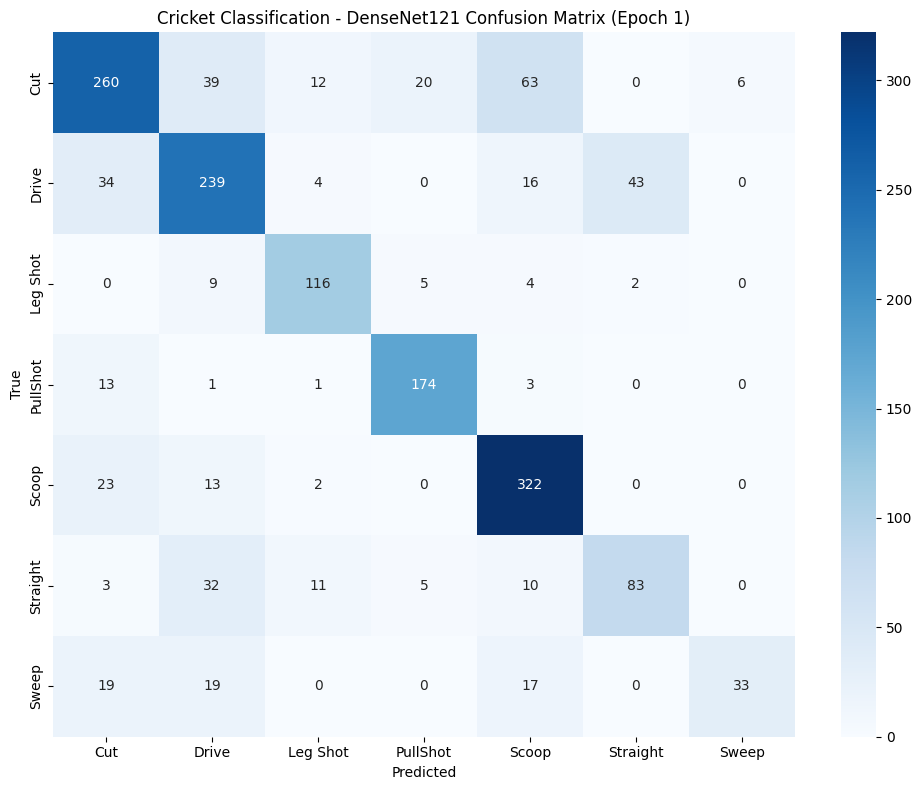

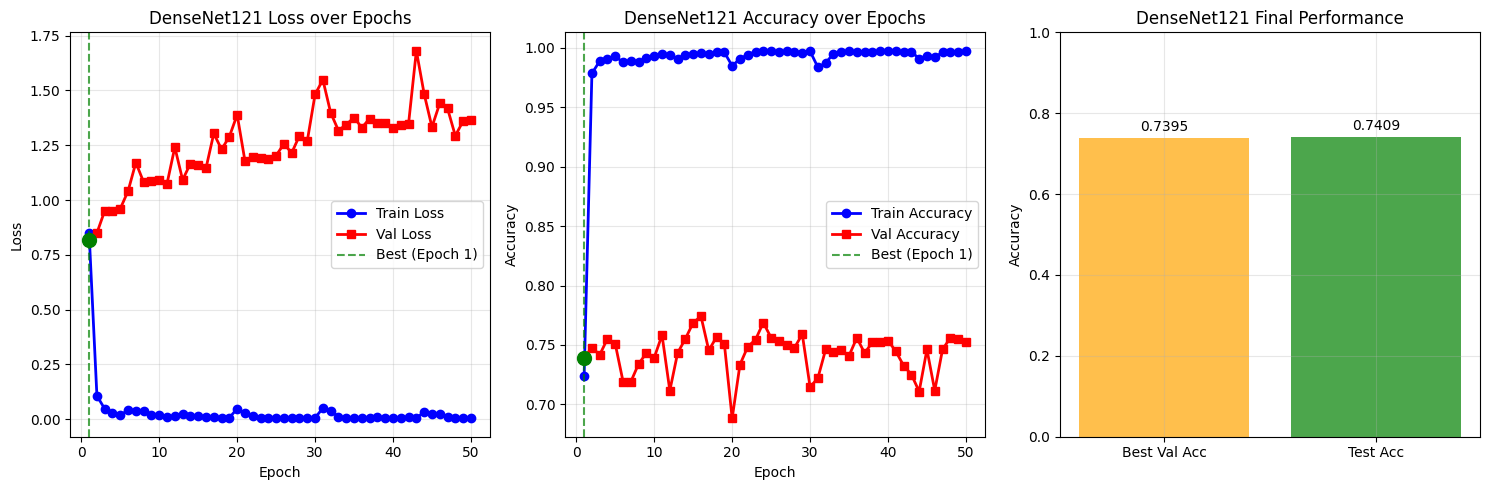


‚è∞ Final Timing Summary:
‚îÇ Total Training: 4914.73s (81.9 min)
‚îÇ Average per Epoch: 98.29s
‚îÇ Testing Time: 21.53s
‚îÇ Total Runtime: 4936.26s

üåê DenseNet121 Advantages:
‚îÇ Dense Connections: Every layer connects to every other layer
‚îÇ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)
‚îÇ Feature Reuse: Excellent gradient flow and feature reuse
‚îÇ Strong Performance: Often matches/exceeds ResNet with fewer parameters


In [10]:
import pandas as pd
import torch.optim as optim
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: DenseNet121 (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting DenseNet121 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_densenet121_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_densenet121.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_densenet121_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_densenet121_history_pretrained.csv'")

print(f"\nüéâ DenseNet121 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (DenseNet121):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_densenet121.pth - Best model weights")
print(f"‚îÇ cricket_densenet121_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - DenseNet121 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("DenseNet121 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("DenseNet121 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\nüåê DenseNet121 Advantages:")
print(f"‚îÇ Dense Connections: Every layer connects to every other layer")
print(f"‚îÇ Parameter Efficient: ~8M parameters (vs ~25M ResNet50)")
print(f"‚îÇ Feature Reuse: Excellent gradient flow and feature reuse")
print(f"‚îÇ Strong Performance: Often matches/exceeds ResNet with fewer parameters")

In [11]:
import tempfile
import os
# Calculate model parameters

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)  # Clean up temporary file

print(f"üìä Total parameters: {total_params:,}")
print(f"üìä Trainable parameters: {trainable_params:,}")
print(f"üìä Model file size: {model_size_mb:.2f} MB")
print(f"üìã Model Architecture:")
print(f"‚îÇ Input size: (3, 224, 224)")
print(f"‚îÇ DenseNet121 features: 1024")
print(f"‚îÇ Output classes: {len(classes)}")
print(f"‚îÇ Memory efficient: Dense connections")
print(f"‚îÇ Growth rate: 32 feature maps per layer")

üìä Total parameters: 6,961,031
üìä Trainable parameters: 6,961,031
üìä Model file size: 27.13 MB
üìã Model Architecture:
‚îÇ Input size: (3, 224, 224)
‚îÇ DenseNet121 features: 1024
‚îÇ Output classes: 7
‚îÇ Memory efficient: Dense connections
‚îÇ Growth rate: 32 feature maps per layer
